In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
import librosa
import librosa.display
import IPython.display as ipd
import numpy as np
import math, random
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn import init
from torch.utils.data import DataLoader, Dataset, random_split
import torchaudio
from torchaudio import transforms
from IPython.display import Audio
from PIL import Image
import sklearn
from sklearn import preprocessing
from scipy.signal import butter, filtfilt
import os
import noisereduce as nr 
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [9]:
# Set a seed for reproducibility
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed_all(seed)  # If using GPU

In [10]:
def denoise(sig, sr, threshold=2.0, is_stationary=True):
    return nr.reduce_noise(y=sig, sr=sr, n_std_thresh_stationary=threshold, stationary=is_stationary)

def rechannel_mono(sig):
    if sig.shape[0] == 1:
        return sig
    else:
        return np.mean(sig, axis=0, keepdims=True)

def resample(sig, sr, new_sr):
    if sr == new_sr:
        return sig

    sig = torch.from_numpy(sig).float()
    resig = torchaudio.transforms.Resample(sr, new_sr)(sig)
    return resig.numpy()

def trim_silence(waveform, threshold=0.01, padding=0):
    # Take the absolute value to get the signal magnitude
    abs_waveform = np.abs(waveform)
    
    # Find indices where the magnitude is above the threshold
    above_threshold = np.where(abs_waveform > threshold)[1 if waveform.ndim == 2 else 0]
    
    # Check if any samples are above the threshold
    if above_threshold.size == 0:
        # If no samples exceed the threshold, return the original waveform
        return waveform
    
    # Determine start and end indices with optional padding
    start = max(above_threshold[0] - padding, 0)
    end = min(above_threshold[-1] + padding, waveform.shape[-1])
    
    # Return the trimmed waveform
    return waveform[..., start:end]

def pad_or_truncate(mfcc, target_length):
    current_length = mfcc.shape[0]
    if current_length > target_length:
        return mfcc[:target_length]  # Truncate if longer than target length
    elif current_length < target_length:
        padding = target_length - current_length
        return np.pad(mfcc, (0, padding), mode='constant')  # Pad with zeros if shorter
    return mfcc

# Extracting Train mfcc Features

In [11]:
metadata = pd.read_csv('./Train.csv')
unique_classes = metadata['class'].unique()
class_mapping = {class_name: idx for idx, class_name in enumerate(unique_classes)}

metadata['classID'] = metadata['class'].map(class_mapping)
metadata= metadata.drop('class', axis=1)
metadata.head()

,id,audio_filepath,duration,classID
0,id_6nazjwygdl,id_6nazjwygdl.wav,1.984,0
1,id_jpwl97yilf,id_jpwl97yilf.wav,2.027,1
2,id_9d131fb32p,id_9d131fb32p.wav,2.274,2
3,id_kat2oty4s0,id_kat2oty4s0.wav,2.176,1
4,id_g3hvae3jbe,id_g3hvae3jbe.wav,1.634,1


In [ ]:
# Define parameters
target_sr = 44100
root_path = "./TechCabal Ewe Audio Files/"

100%|██████████| 5334/5334 [01:15<00:00, 70.35it/s] 


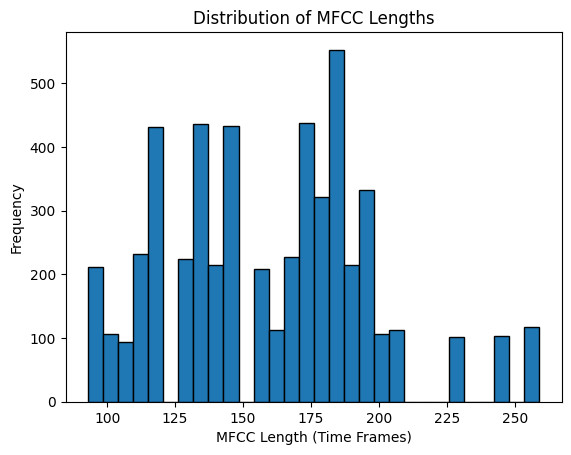

In [13]:
# Collect lengths of MFCCs for each audio file
mfcc_lengths = []

for idx in tqdm(range(len(metadata))):
    file_path = metadata.loc[idx, 'audio_filepath']
    waveform, sr = librosa.load(root_path + file_path, sr=target_sr)
    mfcc = librosa.feature.mfcc(y=waveform, sr=target_sr, n_mfcc=13)
    mfcc_lengths.append(mfcc.shape[1])  # Store the time dimension (number of frames)

# Plot the distribution of MFCC lengths
plt.hist(mfcc_lengths, bins=30, edgecolor='black')
plt.xlabel('MFCC Length (Time Frames)')
plt.ylabel('Frequency')
plt.title('Distribution of MFCC Lengths')
plt.show()

In [14]:
target_mfcc_length = int(np.percentile(mfcc_lengths, 75))  # 75th percentile as target length
print(f"Chosen target length for padding/truncation: {target_mfcc_length}")

Chosen target length for padding/truncation: 184


In [15]:
# Function to preprocess a single audio file and extract flattened MFCC features
def preprocess_audio(file_path):
    sig ,sr = librosa.load(root_path + file_path)
    sig = denoise(sig, sr)
    mfcc = librosa.feature.mfcc(y=sig, sr=sr, n_mfcc=13)
    mfcc_flat = mfcc.flatten()
    mfcc_flat = pad_or_truncate(mfcc_flat, target_mfcc_length)
    return mfcc_flat

In [ ]:
# Paths to save the processed features
train_feature_save_dir = './train_mfcc_features/'
os.makedirs(train_feature_save_dir, exist_ok=True)
train_features_path = os.path.join(train_feature_save_dir, 'features.npy')
train_labels_path = os.path.join(train_feature_save_dir, 'labels.npy')
train_features = []
train_labels = []

# Check if files already exist
if not (os.path.exists(train_features_path) and os.path.exists(train_labels_path)):
   
    # Retrieve and save features and labels for the training set
    print("Processing Train features...")
    for idx, row in tqdm(metadata.iterrows(), total=len(metadata)):
        try:
            file_path = row['audio_filepath']
            label = row['classID']
            
            mfcc_flattened = preprocess_audio(file_path)
            train_features.append(mfcc_flattened)
            train_labels.append(label)
        except Exception as e:
            print('idx at exception:' , idx)
            print('error is :', e)

    train_features_np = np.array(train_features)
    train_labels_np = np.array(train_labels)
   

    # Save arrays to files
    np.save(train_features_path, train_features_np)
    np.save(train_labels_path, train_labels_np)
    print("Train Features and Labels saved to files.")
else:
    print("Train Features and labels already saved. Loading from files...")

Processing Train features...


100%|██████████| 5334/5334 [03:43<00:00, 23.90it/s]

Train Features and Labels saved to files.


In [22]:
# Check shapes
print("Training features shape:", np.load(train_features_path).shape)
print("Training labels shape:",np.load(train_labels_path).shape)

Training features shape: (5334, 184)
Training labels shape: (5334,)


# Extracting Validation mfcc Features

In [29]:
val_metadata = pd.read_csv('./Test_1.csv')
val_metadata.head()

,id,audio_filepath,duration
0,id_u5iqtgjzhx,id_u5iqtgjzhx.wav,2.35800
1,id_l7ebzcfk5e,id_l7ebzcfk5e.wav,3.22100
2,id_jbzci8uepl,id_jbzci8uepl.wav,2.94898
3,id_jzil0fw5vs,id_jzil0fw5vs.wav,4.33100
4,id_o7mrvf5wj7,id_o7mrvf5wj7.wav,1.85600


In [31]:
val_feature_save_dir = './val_mfcc_features/'
os.makedirs(val_feature_save_dir, exist_ok=True)
val_features_path = os.path.join(val_feature_save_dir, 'features.npy')
val_features = []

if not os.path.exists(val_features_path):
    # Retrieve and save features and labels for the training set
    print("Processing Validation Features...")
    for idx, row in tqdm(val_metadata.iterrows(), total=len(val_metadata)):
        try:
            file_path = row['audio_filepath']
            mfcc_flattened = preprocess_audio(file_path)
            val_features.append(mfcc_flattened)
        except Exception as e:
            print('idx at exception:' , idx)
            print('error is :', e)

    val_features_np = np.array(val_features)
   

    # Save arrays to files
    np.save(val_features_path, val_features_np)
    print("Val features saved to file")
else:
    print("Val Features already saved. Loading from files...")

Processing Validation Features...


100%|██████████| 2946/2946 [02:02<00:00, 24.01it/s]

Val features saved to file


In [34]:
print("Validation features shape:", np.load(val_features_path).shape)

Validation features shape: (2946, 196)


# Single sound file feature extraction experimentation

In [26]:
target_sr = 44100
sig, sr = librosa.load(root_path + 'id_6nazjwygdl.wav', sr=target_sr)
print('sig.shape:', sig.shape)

sig.shape: (87495,)


In [27]:
ipd.Audio(data= sig, rate=sr)
print('sr:', sr)
print('sig.shape:', sig.shape)
ipd.Audio(data=sig, rate = sr)

sr: 44100
sig.shape: (87495,)


In [28]:
sig = denoise(sig, sr)
print('sig.shape:', sig.shape)
ipd.Audio(data=sig, rate = sr)

sig.shape: (87495,)


In [29]:
sig = trim_silence(sig)
print('sig.shape:', sig.shape)
ipd.Audio(data=sig, rate = sr)

sig.shape: (70379,)


In [25]:
mfcc = librosa.feature.mfcc(y=sig, sr=target_sr, n_mfcc=13)
print('mfcc.shape', mfcc.shape)

mfcc.shape (13, 137)


In [31]:
mfcc_flat = mfcc.flatten()
mfcc_flat.shape

(1781,)